# Using BERT to Identify the Narrators (Binary Classification)

While binary classification [reliably identifies one of the narrators](2_BERT_binary_classification_bill.ipynb) (Bill Hardy), multiclass classification [performs very poorly](3_BERT_multiclass_classification_WIP.ipynb).

There is some paradox. To investigate it, we can compare the outputs of binary classification applied to each narrator.

In [1]:
%%capture

# make logs less verbose
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# suppress UnparsedFlagAccessError warning
import sys
from absl import flags

sys.argv = ["preserve_unused_tokens=False"]
flags.FLAGS(sys.argv)

# suppress warnings
# (after having ensured they did not impact the analysis)
import warnings

warnings.filterwarnings("ignore")

## Process data

In [2]:
import pandas as pd

df = pd.read_json("./data/jawbone.json")

Augment the data with a column per narrator, `1` if a page belongs to a given narrator, `0` otherwise.

In [3]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()


def get_narrator(id):
    for key, ids in possible_solutions.items():
        if id in ids:
            return key
    return None


df = df.astype({"text": "string"})

# create one boolean column per narrator
dummies = pd.get_dummies(df["page"].apply(lambda x: get_narrator(x)).str.get_dummies())

df = pd.concat([df, dummies], axis=1)
df = df.astype({col: "int" for col in dummies.columns})
df

,page,text,Bill Hardy,Clement DeAth,Henry (dog),Jasmine Gay,John Walker,May Doncaster,Oscar Mills,Sir Paul Trinder
0,1,I sit down alone at the appointed table and ta...,1,0,0,0,0,0,0,0
1,2,I plunged for the last time. The few remaining...,0,0,0,0,0,0,1,0
2,3,"At my meeting with Clement yesterday, he had b...",0,0,0,0,1,0,0,0
3,4,And I really think I would have preferred the ...,1,0,0,0,0,0,0,0
4,5,I hated my eye for being caught by what didn’t...,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
95,96,Now I think I will try a cup of what they inso...,1,0,0,0,0,0,0,0
96,97,To have slept and to wake right up surrounded ...,0,0,0,0,1,0,0,0
97,98,He stood and looked down at me; but I was not ...,0,0,0,0,0,0,0,1
98,99,"And she wore a mauve love-knot on her breast, ...",0,0,1,0,0,0,0,0


In [4]:
# "modernize" the writing
vocabulary = {
    "to-day": "today",
    "for ever": "forever",
    "any more": "anymore",
    "skilful": "skillful",
    "bell-flower": "bellflower",
    "rain-proof": "rainproof",
    "good-bye": "goodbye",
    "to-night": "tonight",
    "parti-panties": "party-panties",
    "spare-room": "spare room",
    "long seed": "long-seed",
    "finger-tips": "fingertips",
    "market place": "marketplace",
    "match box": "matchbox",
    "spare-room": "spare room",
    "grape vine": "grapevine",
    "gold-leaf": "gold leaf",
    "motor boat": "motorboat",
    "May be": "Maybe",
    "salt-cellar": "salt cellar",
    "every one": "everyone",
}

for old, new in vocabulary.items():
    df["text"] = df["text"].str.replace(old, new)

df

,page,text,Bill Hardy,Clement DeAth,Henry (dog),Jasmine Gay,John Walker,May Doncaster,Oscar Mills,Sir Paul Trinder
0,1,I sit down alone at the appointed table and ta...,1,0,0,0,0,0,0,0
1,2,I plunged for the last time. The few remaining...,0,0,0,0,0,0,1,0
2,3,"At my meeting with Clement yesterday, he had b...",0,0,0,0,1,0,0,0
3,4,And I really think I would have preferred the ...,1,0,0,0,0,0,0,0
4,5,I hated my eye for being caught by what didn’t...,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
95,96,Now I think I will try a cup of what they inso...,1,0,0,0,0,0,0,0
96,97,To have slept and to wake right up surrounded ...,0,0,0,0,1,0,0,0
97,98,He stood and looked down at me; but I was not ...,0,0,0,0,0,0,0,1
98,99,"And she wore a mauve love-knot on her breast, ...",0,0,1,0,0,0,0,0


The data is now labeled.

---

The approach used for Bill is transposed to all narrators.

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT base uncased model
# https://huggingface.co/bert-base-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=1
)

In [6]:
import torch

# hyperparameters

num_epochs = 20
learning_rate = 2e-5
batch_size = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The book is sampled for training and testing in the following proportion:

* **4 pages beloging to a given narrator**, and
* **25 pages from other narrators**

The size of the test dataset is 20% of the sampled subset of the book.

In [7]:
from sklearn.model_selection import train_test_split


def get_datasets(df, narrator):
    # sample 40% of the narrator pages/sentences and 25% of all pages/sentences
    df_is_narrator = df[df[narrator] == 1].sample(frac=0.3)
    df_not_narrator = df[df[narrator] == 0].sample(frac=0.3)

    df_sampled = pd.concat([df_is_narrator, df_not_narrator], axis=0)

    print(df_sampled)

    # split datasets
    return train_test_split(
        df_sampled["text"].values,
        df_sampled[narrator].values,
        test_size=None,
        random_state=42,
    )

In [8]:
from torch.utils.data import DataLoader, Dataset


# tokenize and prepare the input data
class TokenizedData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = float(self.labels[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.float32),
        }

In [9]:
from transformers import AdamW
import copy


def train(df, narrator):
    train_texts, _, train_labels, _ = get_datasets(df, narrator)

    train_dataloader = DataLoader(
        TokenizedData(train_texts, train_labels, tokenizer, max_len=256),
        batch_size=batch_size,
        shuffle=True,
    )

    print(f"Train dataset size: {train_texts.shape[0]}")

    model = copy.copy(bert_model)
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in train_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].squeeze().to(device)

            if input_ids.numel() < batch_size or labels.numel() < batch_size:
                continue

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)

            loss = criterion(outputs.logits.flatten(), labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"{epoch + 1}/{num_epochs} — loss: {avg_loss:.4f}")

    return model

## Prediction

In [10]:
from sklearn.metrics import accuracy_score


def eval(model, texts):
    model.eval()

    inputs = tokenizer(
        [text for text in texts],
        return_tensors="pt",
        truncation=True,
        padding=True,
    )
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    probabilities = torch.sigmoid(outputs.logits).cpu().numpy()
    predicted_labels = (probabilities > 0.5).astype(int)

    return predicted_labels

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def generate_confusion_matrix(model, df, predicted_labels, narrator):
    cm = confusion_matrix(df[narrator].values, predicted_labels)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Someone else", narrator]
    )

    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues")

    plt.show()

In [12]:
import matplotlib.patches as mpatches


def represent_pages(df, narrator):
    cols, rows = 10, 10

    expected_pages = [
        page - 1 for page in df[df[narrator] == 1]["page"].values.tolist()
    ]
    predicted_pages = [
        index for index, value in enumerate(predicted_labels.flatten()) if value == 1
    ]

    fig, axs = plt.subplots(rows, cols, figsize=(cols, rows), tight_layout=True)

    for i, ax in enumerate(axs.ravel()):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.add_patch(
            plt.Rectangle(
                (0, 0), 1, 1, fill=True, edgecolor="#000000", facecolor="#FFFFFF"
            )
        )
        row, col = divmod(i, cols)
        ax.text(
            0.5, 0.95, str(i + 1), ha="center", va="top", color="#000000", fontsize=8
        )

    common_indices = set.intersection(set(expected_pages), set(predicted_pages))

    for index in expected_pages + predicted_pages:
        row, col = divmod(index, cols)

        if index in common_indices:
            # pages adequately predicted
            axs[row, col].patches[0].set_facecolor("#FFE871")
            axs[row, col].text(
                0.5, 0.5, "✔", ha="center", va="center", color="green", fontsize=12
            )
        elif index in expected_pages:
            # pages erroneously not predicted
            axs[row, col].patches[0].set_facecolor("#A6B7DE")
            axs[row, col].text(
                0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
            )
        else:
            # pages erroneously predicted
            axs[row, col].patches[0].set_facecolor("#DEA6BA")
            axs[row, col].text(
                0.5, 0.5, "✘", ha="center", va="center", color="red", fontsize=12
            )

    plt.legend(
        handles=[
            mpatches.Patch(color="#FFE871", label="Correct Prediction"),
            mpatches.Patch(color="#A6B7DE", label="Missed Prediction"),
            mpatches.Patch(color="#DEA6BA", label="Incorrect Prediction"),
        ],
        loc="upper center",
        bbox_to_anchor=(0.5, -0.15),
        fancybox=True,
        ncol=3,
    )

    fig.set_size_inches(12, 10)
    plt.subplots_adjust(
        top=0.9, bottom=0.2, left=0.1, right=0.9, hspace=0.1, wspace=0.1
    )

    plt.show()

## Bill Hardy
<img src="https://glthr.com/cj/characters/bill-min.jpg" alt="drawing" width="400"/>

In [13]:
narrator = "Bill Hardy"
model = train(df, narrator)

    page                                               text  Bill Hardy  \
22    23  I hate seeing things like this in the paper. B...           1   
29    30  I see that old dandy has purchased Cape Jasmin...           1   
46    47  Babs now moves across the vision, crowned with...           1   
42    43  This is good. She accepts Lover’s Delight from...           1   
82    83  A flower-seller, fed ruddily, it seemed, on ho...           0   
27    28  I found myself by that one of the windows whic...           0   
11    12  I rubbed my eyes and massaged my temples with ...           0   
72    73  All the artist in me flared up. After all, my ...           0   
90    91  In my youth I had been worried that I bore the...           0   
24    25  After I might just as easily have been a liter...           0   
58    59  What was it I held in my fingers? Looked at in...           0   
4      5  I hated my eye for being caught by what didn’t...           0   
75    76  Looking over at

<Figure size 800x600 with 0 Axes>

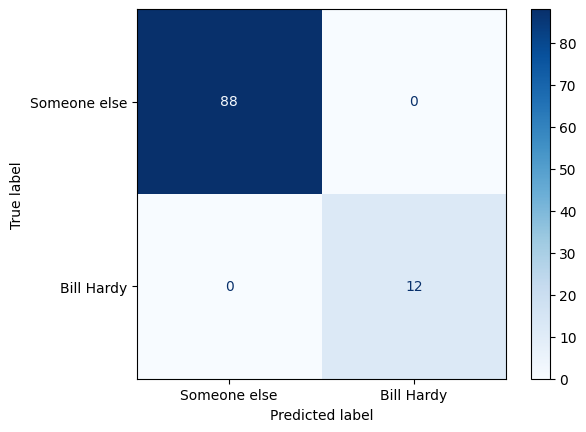

In [14]:
predicted_labels = eval(model, df.text.values)
generate_confusion_matrix(model, df, predicted_labels, narrator)

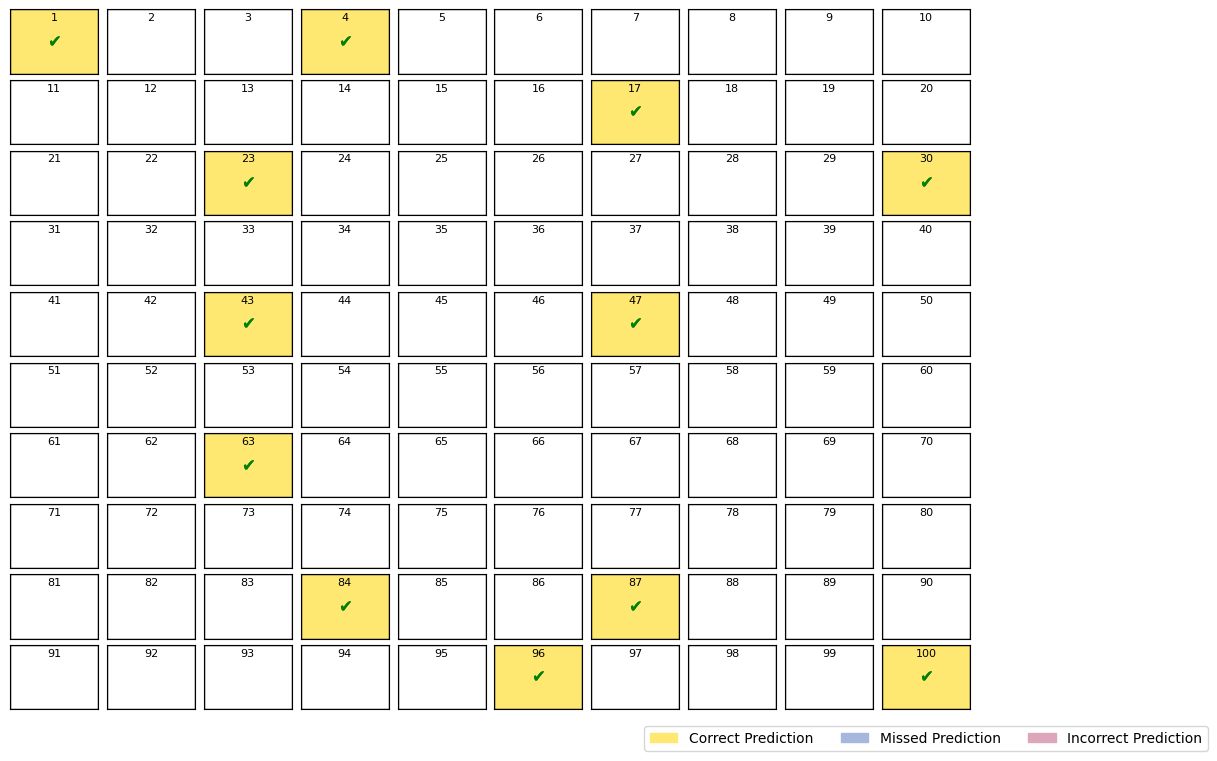

In [15]:
represent_pages(df, narrator)

Applying binary classification to all narrators reveals a compelling finding: Bill Hardy is the only narrator who can be reliably identified, confirming the observation of the multiclass classification results.

Consequently, pages belonging to Bill Hardy have characteristics that distinguish them from other narrators—from the model perspective.

_(TODO: to complete)_